In [587]:
%env KERAS_BACKEND=tensorflow
%matplotlib inline 

env: KERAS_BACKEND=tensorflow


In [632]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider,IntSlider

In [589]:
from keras.models import Sequential, Model
from keras.layers import Input, Lambda, concatenate
from keras.layers import Dense #DNN
from keras.layers import Conv2D, MaxPooling2D #CNN
from keras.layers import Conv2DTranspose, UpSampling2D # RNN
from keras.optimizers import SGD, Adam
from keras import metrics ## 衡量的一些函數
from keras.datasets import mnist # Keras dataset
from keras.utils import np_utils # Keras utilis function
from keras import backend as K

In [590]:
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()
print("There are %d training data with size %d x %d" %x_train0.shape)
print("There are %d testing  data with size %d x %d" %x_test0.shape)

There are 60000 training data with size 28 x 28
There are 10000 testing  data with size 28 x 28


In [591]:
x_train = x_train0.reshape(60000, -1) # 60000 * 784 (-1 就是784)
x_test = x_test0.reshape(10000, -1)
#單位化
x_train -= x_train.min()
x_train = x_train/x_train.max()
x_test -= x_test.min()
x_test = x_test/x_train.max()

In [592]:
enc_1 = Dense(100, activation='sigmoid')
#enc_2 = Dense(2, activation='sigmoid')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

In [593]:
x = Input(shape=(784,))
enc_x = enc_1(x)

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

In [594]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0., stddev=1)## Ｘ～Ｎ（0,1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [595]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var]) ##定義玩還是需要包裝才能使用）

In [596]:
dec_x = dec_2(z)
x_hat = dec_1(dec_x)
VAE = Model(x, x_hat)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_66 (InputLayer)           (None, 784)          0                                            
__________________________________________________________________________________________________
dense_148 (Dense)               (None, 100)          78500       input_66[0][0]                   
__________________________________________________________________________________________________
dense_149 (Dense)               (None, 2)            202         dense_148[0][0]                  
__________________________________________________________________________________________________
dense_150 (Dense)               (None, 2)            202         dense_148[0][0]                  
__________________________________________________________________________________________________
lambda_28 

In [597]:
def vae_loss(x, x_recon):  
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) ## 將 u2=0,sigma_2=1 再玩一玩
    return recovery_loss + kl_loss

In [598]:
VAE.compile(loss=vae_loss, optimizer=Adam())

In [601]:
#VAE.fit(x_train, x_train, batch_size=1024, epochs=128)
VAE.load_weights('VAE_handwriting_model_weights.h5')

In [602]:
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_66 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_148 (Dense)            (None, 100)               78500     
_________________________________________________________________
dense_149 (Dense)            (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


In [603]:
VAE_Decoder = Model(h_input, dec_1(dec_2(h_input)))

VAE_Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_65 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
dense_151 (Dense)            (None, 100)               300       
_________________________________________________________________
dense_152 (Dense)            (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


In [604]:
idx = np.random.randint(x_train.shape[0])
print("第 %d 圖的 latent 表示為 %s" %(idx, VAE_Encoder.predict(x_train[idx: idx+1])))

第 18128 圖的 latent 表示為 [[ 0.39927804 -0.81408787]]


In [605]:
# indices = np.random.randint(x_test.shape[0], size=1000)
VAE_latents = VAE_Encoder.predict(x_test[indices])

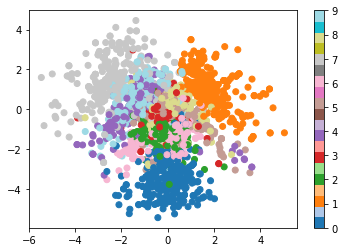

In [606]:
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_test0[indices], cmap='tab20')
plt.colorbar()
plt.show()

In [610]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [615]:

n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)

VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array(  [  [xi, yi]  ]  )
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

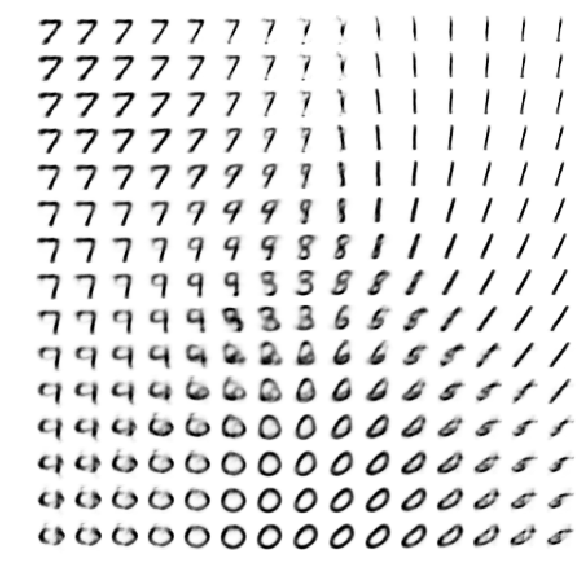

In [616]:
plt.figure(figsize=(10, 10))
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()

In [ ]:
#x=99
#r=5
#sita=30

def circle (x,r,sita,t):
    digit_size=28
    data_0 = x_train0[x]#圓心


    mu_0 = VAE_Encoder.predict(x_train[x:x+1]).squeeze()# 圓心的位置
    cor_X=mu_0[0]+r*np.cos((sita/360)*2*np.pi) ## 把圓面上的點轉成Ｘ座標
    cor_Y=mu_0[1]+r*np.sin((sita/360)*2*np.pi)
    
    corm_X=cor_X*t+mu_0[0]*(1-t) ##  圓心與圓面之間的點的座標
    corm_Y=cor_Y*t+mu_0[1]*(1-t)

    ## decode ！
    z_sample = np.array(  [  [cor_X, cor_Y]  ]  )
    z_samplem = np.array(  [  [corm_X, corm_Y]  ]  )
    
    x_decoded = VAE_Decoder.predict(z_sample)
    
    x_decodedm = VAE_Decoder.predict(z_samplem)
    
    digit = x_decoded[0].reshape(digit_size, digit_size)

    digitm = x_decodedm[0].reshape(digit_size, digit_size)
    
    
    plt.figure(figsize=(5, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(cor_X, cor_Y)
    ax1.scatter(corm_X, corm_Y)

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')

    ax4 = plt.subplot(2, 3, 2)
    ax4.imshow(digitm, cmap='Greys')
    
    ax3 = plt.subplot(2, 3, 3)
    ax3.imshow(digit, cmap='Greys')
    
    ax1.set_xlim(mu_0[0]-r,mu_0[0]+r)
    ax1.set_ylim(mu_0[1]-r,mu_0[1]+r)
    
    ax1.axis('equal')
    
   

In [698]:
np.cos((90/360)*2*np.pi)

6.123233995736766e-17

In [699]:
idx_1, idx_2 = np.random.randint(x_test.shape[0], size=2)
data_0 = x_train0[idx_1]
data_1 = x_train0[idx_2]



In [703]:
print('x=圓心位置 ,r=半徑 , stia=轉的角度,t=再圓心位置與圓面中間的點')

interact(circle, sita=FloatSlider(value=5, 
                                  min=0, 
                                  max=360,
                                  step=1,),
                    r=FloatSlider(value=0.87, 
                                  min=0, 
                                  max=2,
                                  step=0.01,),
                    x=IntSlider(value=30000, 
                                  min=0, 
                                  max=60000-1,
                                  step=1,),
                    t=FloatSlider(value=0.5, 
                                  min=0, 
                                  max=1,
                                  step=0.1,))


x=圓心位置 ,r=半徑 , stia=轉的角度,t=再圓心位置與圓面中間的點


interactive(children=(IntSlider(value=30000, description='x', max=59999), FloatSlider(value=0.87, description=…

<function __main__.circle(x, r, sita, t)>